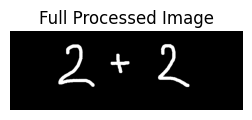

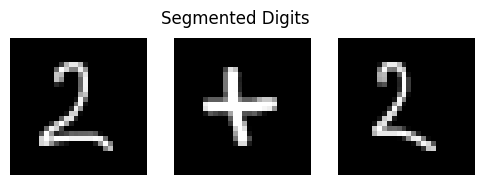

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


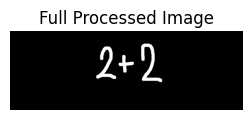

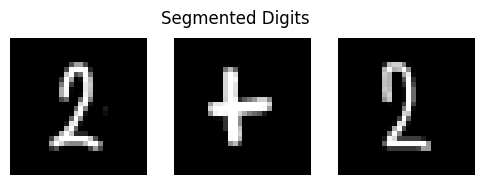

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


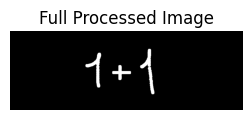

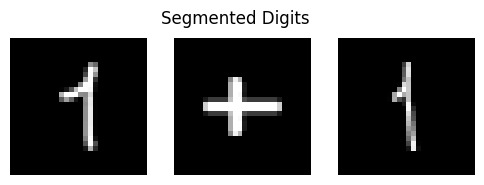

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


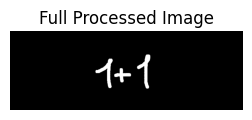

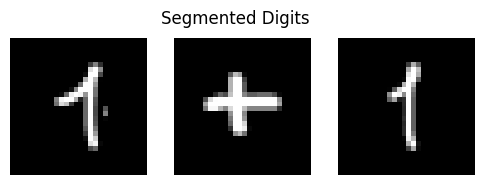

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


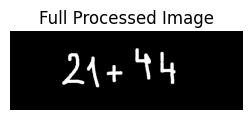

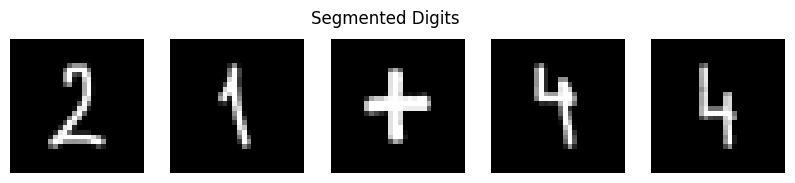

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [15]:
import tkinter as tk
from tkinter import messagebox  # Pop-up dialogs
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import io
import cv2  # OpenCV for segmentation
import tensorflow as tf

# Indices 0-9 correspond to digits '0'..'9',
# index 10 is '+',
# index 11 is '-'
class_names = ["0","1","2","3","4","5","6","7","8","9","+","-"]

# Load your trained MNIST model
model_path = "../joblib/cnn_model_aug.keras"
model = tf.keras.models.load_model(model_path)

def draw(event):
    """Draws a circle (brush stroke) on the canvas where the mouse moves."""
    brush_radius = 6
    x1 = event.x - brush_radius
    y1 = event.y - brush_radius
    x2 = event.x + brush_radius
    y2 = event.y + brush_radius
    canvas.create_oval(x1, y1, x2, y2, fill="black", outline="black")

def clear_canvas():
    """Clears the canvas by deleting all drawn items."""
    canvas.delete("all")
    prediction_label.config(text="Draw digits/signs and click Predict")

def capture_canvas_as_image(tk_canvas):
    """
    Exports the Tkinter canvas to a PostScript string,
    then converts it to a PIL Image.
    """
    ps_data = tk_canvas.postscript(colormode='color')
    img = Image.open(io.BytesIO(ps_data.encode('utf-8')))
    return img

def center_digit(digit_img, final_size=28, target_box=20):
    """Centers a digit in a 28x28 black background."""
    h, w = digit_img.shape
    scale = min(target_box / h, target_box / w)
    new_h = int(h * scale)
    new_w = int(w * scale)
    digit_resized = cv2.resize(digit_img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    output = np.zeros((final_size, final_size), dtype=digit_resized.dtype)
    start_y = (final_size - new_h) // 2
    start_x = (final_size - new_w) // 2
    output[start_y:start_y+new_h, start_x:start_x+new_w] = digit_resized
    return output

def segment_digits(img_array, margin=10):
    """
    Finds contours for multiple digits/signs and returns a list of centered 28×28 arrays.
    """
    _, thresh = cv2.threshold(img_array, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 5 and h > 5:  
            boxes.append((x, y, w, h))
    boxes.sort(key=lambda b: b[0])  # left to right

    digit_images = []
    for (x, y, w, h) in boxes:
        x_margin = max(0, x - margin)
        y_margin = max(0, y - margin)
        w_margin = min(img_array.shape[1], x + w + margin) - x_margin
        h_margin = min(img_array.shape[0], y + h + margin) - y_margin
        cropped = img_array[y_margin:y_margin+h_margin, x_margin:x_margin+w_margin]
        centered = center_digit(cropped, final_size=28, target_box=20)
        digit_images.append(centered)
    return digit_images

def predict_digit():
    # 1) Capture and convert the canvas to grayscale
    img_pil = capture_canvas_as_image(canvas)
    img_pil = img_pil.convert("L")
    img_pil = ImageOps.invert(img_pil)
    img_array = np.array(img_pil)

    # 2) (Optional) Show debug image
    plt.figure(figsize=(3,3))
    plt.imshow(img_array, cmap='gray')
    plt.title("Full Processed Image")
    plt.axis('off')
    plt.show()

    # 3) Segment
    digit_arrays = segment_digits(img_array)

    # (Optional) Debug: show each segmented digit
    if digit_arrays:
        fig, axes = plt.subplots(1, len(digit_arrays), figsize=(2*len(digit_arrays), 2))
        if len(digit_arrays) == 1:
            axes = [axes]
        for ax, digit_img in zip(axes, digit_arrays):
            ax.imshow(digit_img, cmap='gray')
            ax.axis('off')
        plt.suptitle("Segmented Digits")
        plt.show()
    else:
        print("No digits detected!")

    # 4) Predict each segment
    predictions = []
    for digit_arr in digit_arrays:
        digit_norm = digit_arr.astype(np.float32) / 255.0
        digit_norm = np.reshape(digit_norm, (1, 28, 28, 1))
        output = model.predict(digit_norm)
        pred_label_index = np.argmax(output, axis=1)[0]
        class_label = class_names[pred_label_index]
        predictions.append(class_label)

    # 5) Show the recognized string on the label
    result_str = "".join(predictions)
    prediction_label.config(text=f"Predicted: {result_str}")

    # 6) Evaluate and show in a popup
    try:
        solution = eval(result_str)  # e.g. '2+2' -> 4
        messagebox.showinfo("Solution", f"{result_str} = {solution}")
    except:
        messagebox.showerror("Error", "Unable to evaluate the expression")

# ------------------- Setup the GUI -------------------
root = tk.Tk()
root.title("Digit Classifier & Equation Solver")

canvas_width = 900
canvas_height = 300
canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg="white")
canvas.grid(row=0, column=0, columnspan=2, pady=10)

# Bind mouse drag events for drawing
canvas.bind("<B1-Motion>", draw)

# Label & Buttons
prediction_label = tk.Label(root, text="Draw digits/signs and click Predict", font=("Helvetica", 16))
prediction_label.grid(row=1, column=0, columnspan=2, pady=(0,10))

btn_clear = tk.Button(root, text="Clear", command=clear_canvas)
btn_clear.grid(row=2, column=0, padx=10, pady=10)

btn_predict = tk.Button(root, text="Predict", command=predict_digit)
btn_predict.grid(row=2, column=1, padx=10, pady=10)

root.mainloop()
